---
title: OSM - cityseer
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [2]:
import osmnx as ox
from shapely import geometry
import utm

from cityseer.tools import graphs, plot, io

# centrepoint
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buffer_dist = 1250
buffer_poly = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buffer_poly.bounds


# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=4,
        edge_width=1,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(6, 6),
        dpi=150,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=buffer_dist, simplify=False)

## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `io.nx_from_osm_nx` method).


INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 6036/6036 [00:00<00:00, 6949.74it/s]
INFO:cityseer.tools.plot:Preparing graph nodes
INFO:cityseer.tools.plot:Preparing graph edges
100%|██████████| 3595/3595 [00:00<00:00, 24093.22it/s]


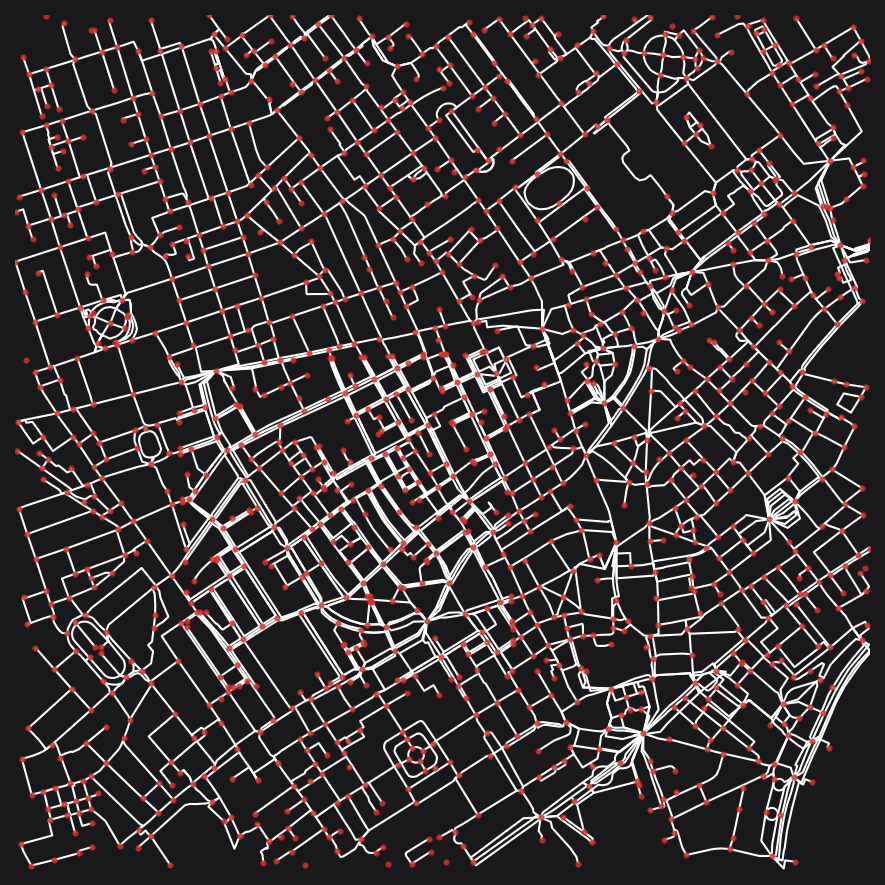

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(
    multi_di_graph_simpl, tolerance=10, dead_ends=True
)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = io.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to immediately convert the `osmnx` graph to `cityseer` before downstream processing. This is preferable because it is then easier for `cityseer` to retain the integrity of the roadway geometries while enforcing node coordinate validation for intersections.


In [4]:
# WORKFLOW 2: Using cityseer to manually clean an OSMnx graph
# ===========================================================
G_raw = io.nx_from_osm_nx(multi_di_graph_raw)

INFO:cityseer.tools.io:Converting OSMnx MultiDiGraph to cityseer MultiGraph.


100%|██████████| 30898/30898 [00:05<00:00, 6051.42it/s]


In [5]:
G = io.nx_wgs_to_utm(G_raw)
G = graphs.nx_simple_geoms(G)
G = graphs.nx_remove_filler_nodes(G)
G = graphs.nx_remove_dangling_nodes(G)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 15843/15843 [00:00<00:00, 534915.06it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 18245/18245 [00:02<00:00, 7650.99it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 18245/18245 [00:00<00:00, 82363.50it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 15843/15843 [00:01<00:00, 8366.39it/s] 
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 5475/5475 [00:00<00:00, 308189.48it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 4989/4989 [00:00<00:00, 66268.22it/s]


INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 4759/4759 [00:00<00:00, 63996.89it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 4759/4759 [00:01<00:00, 2614.08it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 2592/2592 [00:00<00:00, 108947.33it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 4542/4542 [00:00<00:00, 6858.53it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 3955/3955 [00:00<00:00, 813758.76it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 2556/2556 [00:01<00:00, 1912.38it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 25.
100%|██████████| 4305/4305 [00:00<00:00, 190738.79it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 2906/2906 [00:00<00:00, 82582.83it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 2906/2906 [00:00<00:00, 5210.13it/s]
INFO:cityseer.too

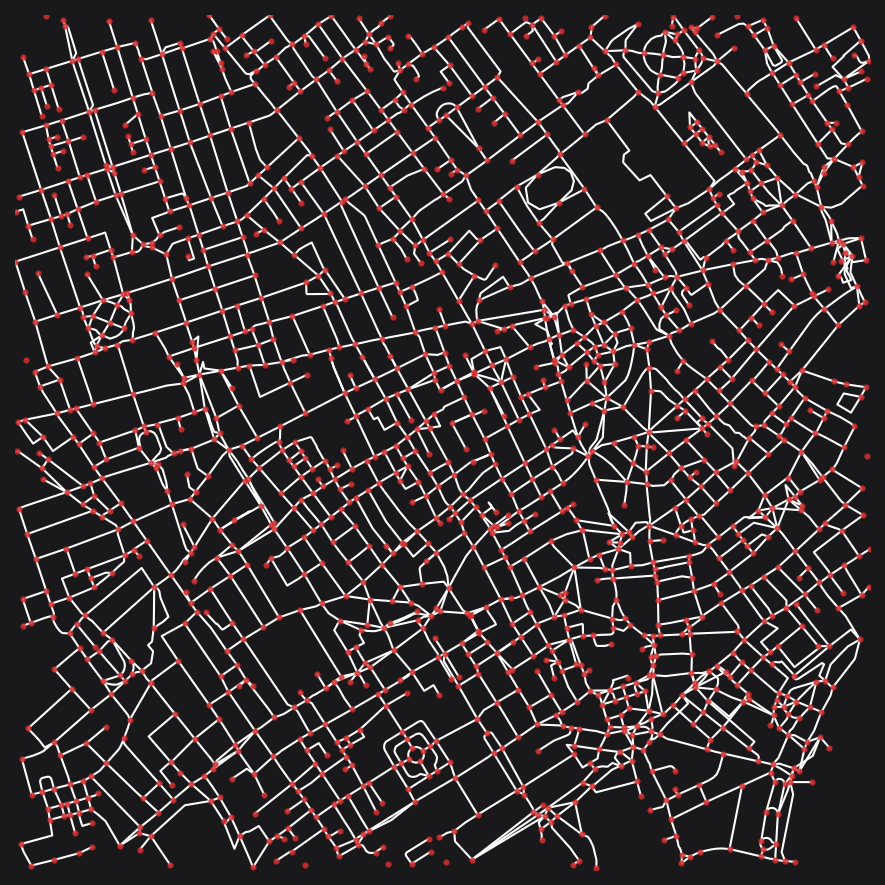

In [6]:
G1 = graphs.nx_consolidate_nodes(G, buffer_dist=12, crawl=True)
G2 = graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = graphs.nx_consolidate_nodes(G2, buffer_dist=15, neighbour_policy="indirect")
G4 = graphs.nx_remove_filler_nodes(G3)
G5 = graphs.nx_iron_edges(G4)
simple_plot(G5)

## Workflow 3

A further option is to simply download the OSM graph directly from within `cityseer`. The following uses a default OSM query, however, the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) can be used to roll-your-own. See documentation for more information.


INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 12102/12102 [00:00<00:00, 524347.58it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 13412/13412 [00:00<00:00, 1090764.65it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 13412/13412 [00:00<00:00, 81558.28it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 12102/12102 [00:01<00:00, 8530.22it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4092/4092 [00:00<00:00, 199406.21it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3298/3298 [00:00<00:00, 32669.64it/s]
INFO:cityseer.tools.util:Creating nodes STR tree
100%|██████████| 2946/2946 [00:00<00:00, 80991.71it/s]
INFO:cityseer.tools.graphs:Consolidating nodes.
100%|██████████| 2946/2946 [00:00<00:00, 3238.10it/s]
INFO:cityseer.tool

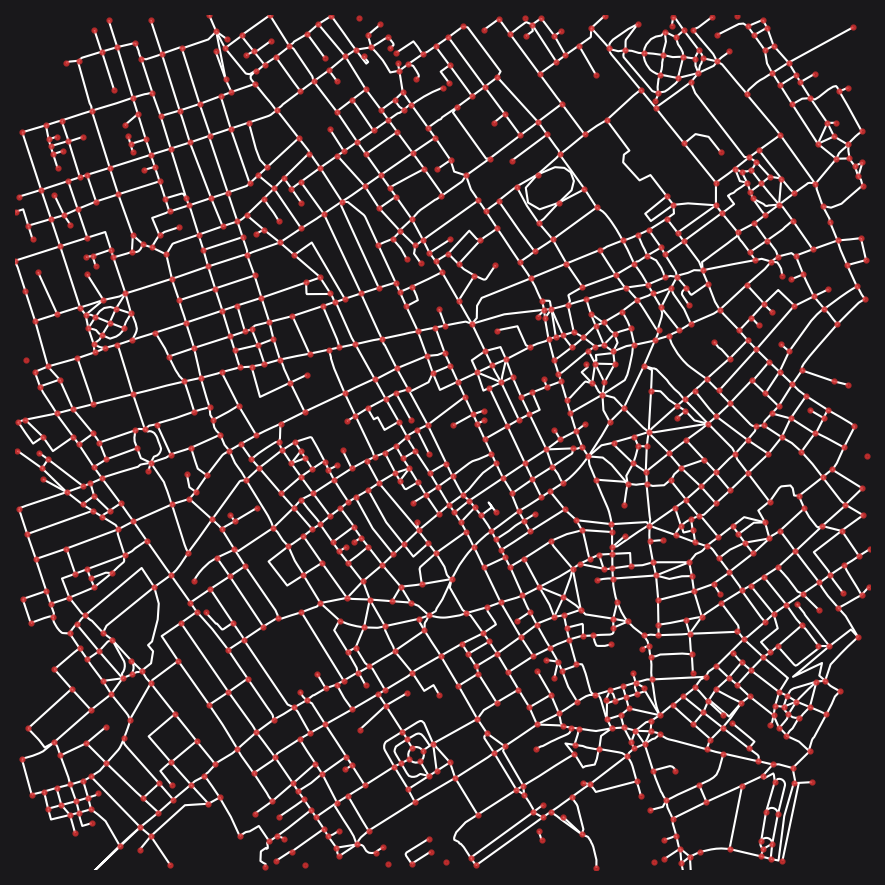

In [7]:
# WORKFLOW 3: Using cityseer to download and automatically simplify the graph
# ===========================================================================
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer_dist)
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
simple_plot(G_utm)